## 算式识别
- 总体概论


## 步骤0
### 导入数据集

label:
['(0+0)+9=9' '9*8+6=78' '1+7+0=8' '5+4+9=18' '7-(1*7)=0']
name of images:
['train/0.jpg' 'train/1.jpg' 'train/2.jpg' 'train/3.jpg' 'train/4.jpg']
数据集共有图片：100000
(64, 300, 3)


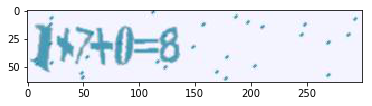

In [24]:
import pandas as pd
from sklearn.datasets import load_files 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

 # 加载标签数据
labels_file = pd.read_csv('train.csv')
label = np.array(labels_file['label'])
file_names = np.array(labels_file['filename'])

# 显示数据结构
print('label:')
print(label[:5])
print('name of images:')
print(file_names[:5])
print('数据集共有图片：%d' % len(file_names))

# 展示图片sample
img = Image.open('train/2.jpg')
print(np.array(img).shape)
plt.imshow(img)
plt.show()

In [21]:
from tqdm import tqdm

# 用PIL进行图片加载，并转换为灰度格式 
def covert_store_gray_img(img_path, store_path):
    '''read images to destination, covert to gray'''
    img = Image.open(img_path).convert('L')
    img.save(store_path)
    return img

# img = covert_store_gray_img('train/0.jpg', '0000.jpg')
# print(np.array(img))

# 设置转换灰度图片的地址到‘covert/’
destination_path = ['covert' + file_name[5:] for file_name in file_names]

# 将所有图片转化层灰度图片到目标文件夹
all_images = [covert_store_gray_img(file_names[i], destination_path[i]) for i in range(len(file_name))]

# 将图片转化为数组
def img_to_array(img_path):
    img = image.open(img_path)
    return np.array(img.getdata()).reshape(64, 300)

# 所有图片批量转化为数组
def all_to_array(img_paths):
    list_of_tensors = [img_to_array(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)









# 将所有训练数据储存在train_data中
train_data = all_to_array(destination_path)

[[247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]
 ..., 
 [247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]]
['covert/0.jpg', 'covert/1.jpg', 'covert/2.jpg', 'covert/3.jpg', 'covert/4.jpg', 'covert/5.jpg', 'covert/6.jpg', 'covert/7.jpg', 'covert/8.jpg', 'covert/9.jpg']


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [36]:
# 实验代码
from keras.preprocessing.image import ImageDataGenerator

imgs = [covert_store_gray_img(file_names[i], destination_path[i]) for i in range(5)]

# 将图片转化为数组
def img_to_array(img):
    return np.array(img)

print([img_to_array(img) for img in imgs])

data_gen = ImageDataGenerator(rescale=1. / 255, validation_split=0.1)

train_generator = data_gen.flow_from_directory('covert/',
                                               target_size=(64, 300),
                                               batch_size=100,
                                               class_mode='categorical', subset='training')

validation_generator = data_gen.flow_from_directory('covert/',
                                               target_size=(64, 300),
                                               batch_size=100,
                                               class_mode='categorical', subset='validation')

# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
#         model.fit(x_batch, y_batch)
#         batches += 1
#         if batches >= len(x_train) / 32:
#             # 我们需要手动打破循环，
#             # 因为生成器会无限循环
#             break


[array([[247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247],
       ..., 
       [247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247],
       [247, 247, 247, ..., 247, 247, 247]], dtype=uint8), array([[244, 244, 244, ..., 245, 245, 245],
       [244, 244, 244, ..., 245, 245, 245],
       [244, 244, 245, ..., 245, 245, 245],
       ..., 
       [240, 243, 222, ..., 245, 245, 245],
       [243, 238, 247, ..., 245, 245, 245],
       [244, 239, 241, ..., 245, 245, 245]], dtype=uint8), array([[245, 245, 245, ..., 246, 245, 244],
       [244, 244, 244, ..., 245, 246, 244],
       [244, 244, 244, ..., 244, 244, 244],
       ..., 
       [245, 245, 245, ..., 245, 245, 245],
       [244, 244, 245, ..., 245, 245, 245],
       [244, 244, 244, ..., 245, 245, 245]], dtype=uint8), array([[251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 251, 251],
       [251, 251, 251, ..., 251, 25

In [43]:
def img_to_array(img_path):
    img = Image.open(img_path)
    return np.array(img.getdata())

array = img_to_array('covert/0.jpg')
a = array.reshape(64, 300)
print(a)

# from keras.preprocessing import image 
# img = image.load_img('covert/0.jpg', target_size=(64, 300))

[[247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]
 ..., 
 [247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]
 [247 247 247 ..., 247 247 247]]
